In [1]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'cat-and-dog-images-dataset:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F927899%2F1570061%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240313%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240313T164701Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D2ac5102405785f31f372eb7e292c0576798de72bb82542acce6238c90fbd2e3ccefd0ad05e88b6d72fd5f6e13a9857df6fc1750632e9419ec0f8f2d09410eeb88014a50a1c1e80b3dd3c3f15c627792e2f85be837b03ebe3f6e3586445fdec51c092ea6119986ce5051aa0fed848ac6b92ea53425d5a8589d7e2206202545abbab8af03d33cf9f5dafb0c618566b28456ce16773f7d46c87df32790cd30198b97cd86b7ad048cdb930a639ce36542e03d72c675f7f3da5e9fa21d673af77217a48cbf06aa93e66c6f1c586736f2098cc170b93baf252cc3a97de8954f5d1ab4e010b93cdce21d15a8efd028bed61e051cab85a4b15f8ef9c268f843a57f690c4'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 134101030 bytes downloaded
Downloaded and uncompressed: cat-and-dog-images-dataset
Data source import complete.


# Task for Today  

***

## Cat and Dog Classification  

Given *images of cats and dogs*, let's try to classify which **pet** is present in a given image.

We will use a TensorFlow/Keras CNN to make our predictions.

# Getting Started

In [2]:
import numpy as np
import pandas as pd
from pathlib import Path
import os.path

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

import tensorflow as tf

from sklearn.metrics import confusion_matrix, classification_report

In [3]:
image_dir = Path('../input/cat-and-dog-images-dataset/Dog and Cat .png')

# Create File DataFrame

In [4]:
filepaths = list(image_dir.glob(r'**/*.png'))
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

image_df = pd.concat([filepaths, labels], axis=1)

In [5]:
image_df

,Filepath,Label
0,../input/cat-and-dog-images-dataset/Dog and Ca...,Dog
1,../input/cat-and-dog-images-dataset/Dog and Ca...,Dog
2,../input/cat-and-dog-images-dataset/Dog and Ca...,Dog
3,../input/cat-and-dog-images-dataset/Dog and Ca...,Dog
4,../input/cat-and-dog-images-dataset/Dog and Ca...,Dog
...,...,...
994,../input/cat-and-dog-images-dataset/Dog and Ca...,Cat
995,../input/cat-and-dog-images-dataset/Dog and Ca...,Cat
996,../input/cat-and-dog-images-dataset/Dog and Ca...,Cat
997,../input/cat-and-dog-images-dataset/Dog and Ca...,Cat


In [6]:
train_df, test_df = train_test_split(image_df, train_size=0.7, shuffle=True, random_state=1)

# Load Image Data

In [7]:
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True,
    width_shift_range=0.2,
    height_shift_range=0.2,
    validation_split=0.2
)

test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255
)

In [8]:
train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='binary',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='training'
)

val_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='binary',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='validation'
)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='binary',
    batch_size=32,
    shuffle=False
)

Found 560 validated image filenames belonging to 2 classes.
Found 139 validated image filenames belonging to 2 classes.
Found 300 validated image filenames belonging to 2 classes.


# Training

In [13]:
inputs = tf.keras.Input(shape=(224, 224, 3))
x = tf.keras.layers.Conv2D(filters=16, kernel_size=(3, 3), activation='relu')(inputs)
x = tf.keras.layers.MaxPool2D()(x)
x = tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu')(x)
x = tf.keras.layers.MaxPool2D()(x)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    train_images,
    validation_data=val_images,
    epochs=100,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=5,
            restore_best_weights=True
        ),
        tf.keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss',
            patience=3
        )
    ]
)

Epoch 1/100
18/18 [==============================] - 37s 2s/step - loss: 0.6913 - accuracy: 0.5286 - val_loss: 0.6906 - val_accuracy: 0.4964 - lr: 0.0010
Epoch 2/100
18/18 [==============================] - 30s 2s/step - loss: 0.6883 - accuracy: 0.5661 - val_loss: 0.6899 - val_accuracy: 0.4964 - lr: 0.0010
Epoch 3/100
18/18 [==============================] - 31s 2s/step - loss: 0.6829 - accuracy: 0.5411 - val_loss: 0.6740 - val_accuracy: 0.6331 - lr: 0.0010
Epoch 4/100
18/18 [==============================] - 30s 2s/step - loss: 0.6774 - accuracy: 0.5804 - val_loss: 0.6600 - val_accuracy: 0.6187 - lr: 0.0010
Epoch 5/100
18/18 [==============================] - 30s 2s/step - loss: 0.6672 - accuracy: 0.5804 - val_loss: 0.6557 - val_accuracy: 0.5971 - lr: 0.0010
Epoch 6/100
18/18 [==============================] - 30s 2s/step - loss: 0.6710 - accuracy: 0.5696 - val_loss: 0.6510 - val_accuracy: 0.6763 - lr: 0.0010
Epoch 7/100
18/18 [==============================] - 29s 2s/step - loss: 0.6

# Results

In [14]:
results = model.evaluate(test_images, verbose=0)

print("    Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

    Test Loss: 0.65050
Test Accuracy: 60.67%


10/10 [==============================] - 4s 317ms/step


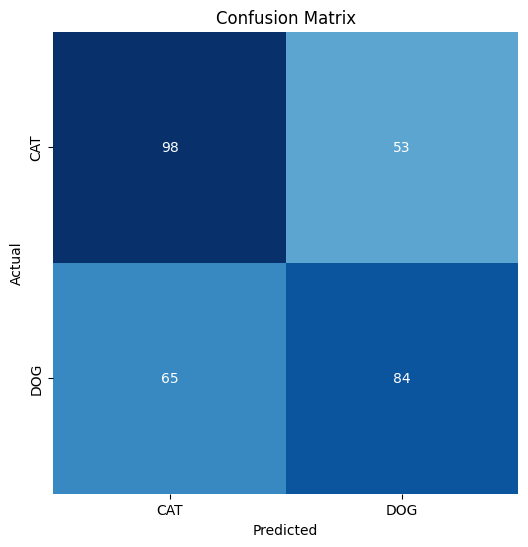

Classification Report:
----------------------
               precision    recall  f1-score   support

         CAT       0.60      0.65      0.62       151
         DOG       0.61      0.56      0.59       149

    accuracy                           0.61       300
   macro avg       0.61      0.61      0.61       300
weighted avg       0.61      0.61      0.61       300



In [20]:
import numpy as np
predictions = (model.predict(test_images) >= 0.5).astype(np.int16)

cm = confusion_matrix(test_images.labels, predictions, labels=[0, 1])
clr = classification_report(test_images.labels, predictions, labels=[0, 1], target_names=["CAT", "DOG"])

plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='g', vmin=0, cmap='Blues', cbar=False)
plt.xticks(ticks=[0.5, 1.5], labels=["CAT", "DOG"])
plt.yticks(ticks=[0.5, 1.5], labels=["CAT", "DOG"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

print("Classification Report:\n----------------------\n", clr)